In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# the directory where your data is
#PATH_to_data = '/content/drive/My Drive/STROKE_code/MMPOSE/data/patient_output/processed/NIHSS/'
PATH_to_data = '/content/drive/My Drive/'
import os
os.chdir(PATH_to_data)
import sys
sys.path.append(PATH_to_data)

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

import numpy as np
import pandas as pd
# Set the display option to show all columns
pd.set_option('display.max_columns', None)

#import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join, dirname, abspath

# the length of records (if shorter, we need to add some zero rows)
NUMBER_TIMESTEPS = 500
# the number of features (from the data)
NUMBER_FEATURES = 24 # 22 or 24 if you add shoulders

In [ ]:
#import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join, dirname, abspath

# the length of records (if shorter, we need to add some zero rows)
NUMBER_TIMESTEPS = 500
# the number of features (from the data)
NUMBER_FEATURES = 24 # 22 or 24 if you add shoulders

In [ ]:
# SPECIAL CLEANED DATASET
#clean = pd.read_csv('cleaned_merged_stroke.csv') #short
clean = pd.read_csv('cleaned_slided_stroke.csv') #long slided
clean.head()

In [ ]:
# Apply sliding window with a step to your data and save it
'''
# Define sliding window size
window_size = NUMBER_TIMESTEPS # =500  # Adjust this as needed
step_size = 100  # Adjust this to the desired step size

# Function to create sliding window indices within a fragment with a step
def sliding_window_indices(df_length):
    return [(i, i + window_size) for i in range(0, df_length - window_size + 1, step_size)]

# Apply sliding window within each fragment
result_indices = []
for _, fragment_df in clean.groupby('fragment'):
    indices = sliding_window_indices(len(fragment_df))
    result_indices.extend([(fragment_df.index[start:end]) for start, end in indices])

# Combine the results into a new dataframe
result = clean.loc[pd.Index(np.concatenate(result_indices))]
len(result)

# Save the result as a CSV file
result.to_csv('cleaned_slided_stroke.csv', index=True)

# Save the result as a .npy file
#np.save('cleaned_slided_stroke.npy', result.to_records(index=True))
'''

# Visualize the sliding window
'''
import matplotlib.pyplot as plt
# Plot the data
for fragment, fragment_df in result.groupby('fragment'):
    plt.figure()
    plt.plot(fragment_df['date'], fragment_df['l_degr'], marker='o')
    plt.title(f'Fragment {fragment} Sliding Windows')
    plt.xlabel('date')
    plt.ylabel('l_degr')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
plt.show()
'''

In [ ]:
len(clean)

In [ ]:
clean['left-2'].value_counts(normalize=True)

In [ ]:
clean['left-2'].value_counts(normalize=False)

In [ ]:
# Calculate the number of occurrences of each class in the "fragment" column and print them out
fragment_counts = clean['fragment'].value_counts()
print( fragment_counts.sort_values() )

In [ ]:
#clean[clean['fragment'] == 0]

In [ ]:
# Define a custom function to cut each class to be a multiple of 500
def cut_to_multiple(df, length=500):
    return df.iloc[:len(df) // length * length]

# Group the dataframe by "class" and apply the custom function to each group
clean = clean.groupby('fragment').apply(cut_to_multiple).reset_index(drop=True)

<ipython-input-38-cb2eb518e71f>:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  clean = clean.groupby('fragment').apply(cut_to_multiple).reset_index(drop=True)


In [ ]:
print('The new number of separated fragments: ', len(clean['fragment'].unique()))

print('The new number of patients: ', len(clean['patient_ID'].unique()))

The new number of separated fragments:  17
The new number of patients:  9


In [ ]:
# Calculate the number of occurrences of each class in the "fragment" column and print them out
fragment_counts = clean['fragment'].value_counts()
print( fragment_counts.sort_values() )

71      500
23      500
20      500
0      1000
63     1500
19     3000
22     3500
69     5500
11     7500
61    18500
16    19500
18    21000
25    30000
15    31500
9     33000
7     56000
8     59500
Name: fragment, dtype: int64


In [ ]:
# Print all unique values in column 'patient_ID'
print(clean['patient_ID'].unique())

['DD_18' 'OM_17' 'PC_06' 'LH_24' 'ND_11' 'LC_19' 'RO_26' 'VK_16' 'IM_38']


In [ ]:
len(clean)

292500

In [ ]:
 #LC_19 та DD-18

# Remove rows where 'b' is equal to 'abc'
#clean = clean[  (clean['patient_ID'] != 'DD_18')  ]# & (clean['patient_ID'] != 'LC_19')]

In [ ]:
# Print all unique values in column 'patient_ID'
print(clean['patient_ID'].unique())

['DD_18' 'OM_17' 'PC_06' 'LH_24' 'ND_11' 'LC_19' 'RO_26' 'VK_16' 'IM_38']


In [ ]:
len(clean)

292500

In [ ]:
clean['L Motor Arm Score'].value_counts(normalize=True)

4    0.613675
0    0.365812
1    0.020513
Name: L Motor Arm Score, dtype: float64

In [ ]:
# Group by columns 'a' and 'b', then count the frequency
combination_frequency = clean.groupby(['patient_ID', 'fragment']).size()

In [ ]:
combination_frequency

patient_ID  fragment
DD_18       0            1000
IM_38       69           5500
            71            500
LC_19       25          30000
LH_24       15          31500
            16          19500
            18          21000
            19           3000
ND_11       20            500
            22           3500
            23            500
OM_17       7           56000
            8           59500
            9           33000
PC_06       11           7500
RO_26       61          18500
VK_16       63           1500
dtype: int64

In [ ]:
# Define a custom function to map 'nihss' values to 'opposite-2'
'''
def map_class(nihss_value):
    if nihss_value == 88:
        return 999
    elif 0 <= nihss_value <= 3:
        return 0
    elif nihss_value == 4:
        return 1
    else:
        return None  # You can handle other cases as needed

# Create the 'class-2' column based on the 'nihss' values
clean['left-123'] =  clean['L Motor Arm Score'].apply(map_class)

clean['left-123'].value_counts(normalize=True)
'''

"\ndef map_class(nihss_value):\n    if nihss_value == 88:\n        return 999\n    elif 0 <= nihss_value <= 3:\n        return 0\n    elif nihss_value == 4:\n        return 1\n    else:\n        return None  # You can handle other cases as needed\n\n# Create the 'class-2' column based on the 'nihss' values\nclean['left-123'] =  clean['L Motor Arm Score'].apply(map_class)\n\nclean['left-123'].value_counts(normalize=True)\n"

In [ ]:
# Filter rows where 'left-opposite-2' is 0 or 2
#clean = clean[(clean['left-opposite-2'] == 0) | (clean['left-opposite-2'] == 2)]

In [ ]:
# SPECIAL CLEANED DATASET
X = clean[ ['fragment', 'date', 'X1', 'Y1', 'X2', 'Y2', 'X3', 'Y3', 'X4', 'Y4', 'X5', 'Y5', 'X6', 'Y6', 'X7', 'Y7', 'X8', 'Y8', 'X9', 'Y9', 'X10', 'Y10', 'l_degr', 'r_degr', 'l_shoulder', 'r_shoulder'] ]
Y = clean[ ['fragment', 'date', 'NIHSS', 'L Motor Arm Score', 'R Motor Arm Score', 'L Motor Leg Score', 'R Motor Leg Score', 'left-2', 'right-2', 'left-opposite-2', 'right-opposite-2'] ] # - date

print('X=',X.columns.to_list())
print('Y=',Y.columns.to_list())

X= ['fragment', 'date', 'X1', 'Y1', 'X2', 'Y2', 'X3', 'Y3', 'X4', 'Y4', 'X5', 'Y5', 'X6', 'Y6', 'X7', 'Y7', 'X8', 'Y8', 'X9', 'Y9', 'X10', 'Y10', 'l_degr', 'r_degr', 'l_shoulder', 'r_shoulder']
Y= ['fragment', 'date', 'NIHSS', 'L Motor Arm Score', 'R Motor Arm Score', 'L Motor Leg Score', 'R Motor Leg Score', 'left-2', 'right-2', 'left-opposite-2', 'right-opposite-2']


In [ ]:
# First, we need to create a new column to identify the chunks of 500 rows
X['chunk'] = X.index // 500
Y['chunk'] = Y.index // 500

X['chunk'].unique()

<ipython-input-50-341d0e818f8f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['chunk'] = X.index // 500
<ipython-input-50-341d0e818f8f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['chunk'] = Y.index // 500


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
# how much data will go to the TEST dataset
cur_test_size = 0.3 #30%

''' '''
# Now, we can use the numpy.random.choice function to randomly select chunks for the test set
test_chunks = np.random.choice(X['fragment'].unique(), size=int( len(X['fragment'].unique())*cur_test_size), replace=False)

# Split the DataFrame into train and test subsets
# We can then use the isin method to create a boolean mask to select the rows for the test set
test_mask = X['fragment'].isin(test_chunks)

# Finally, we can use the boolean mask to split the data into train and test sets
X_train = X[~test_mask]
X_test = X[test_mask]

Y_train = Y[~test_mask]
Y_test = Y[test_mask]

print('X Train shape:', X_train.shape)
print('X Test shape:', X_test.shape)

print('Y Train shape:',  Y_train.shape)
print('Y Test shape:',   Y_test.shape)

X Train shape: (208500, 27)
X Test shape: (84000, 27)
Y Train shape: (208500, 12)
Y Test shape: (84000, 12)


In [ ]:
Y_train['left-2'].value_counts(normalize=True)

1    0.57554
0    0.42446
Name: left-2, dtype: float64

In [ ]:
Y_train[ ['left-2','fragment'] ].value_counts(normalize=True)

left-2  fragment
1       7           0.268585
        9           0.158273
0       15          0.151079
1       25          0.143885
0       18          0.100719
        61          0.088729
        11          0.035971
        69          0.026379
        22          0.016787
1       0           0.004796
0       20          0.002398
        23          0.002398
dtype: float64

In [ ]:
Y_test['left-2'].value_counts(normalize=True)

1    0.708333
0    0.291667
Name: left-2, dtype: float64

In [ ]:
Y_test[ ['left-2','fragment'] ].value_counts(normalize=True)

left-2  fragment
1       8           0.708333
0       16          0.232143
        19          0.035714
        63          0.017857
        71          0.005952
dtype: float64

In [ ]:
'''
0, 7, 8, 9, 25
'''

'\n0, 7, 8, 9, 25\n'

In [ ]:
Y_test['left-2']

57000     1
57001     1
57002     1
57003     1
57004     1
         ..
292495    0
292496    0
292497    0
292498    0
292499    0
Name: left-2, Length: 84000, dtype: int64

In [ ]:
Y_test['left-2'].value_counts(normalize=True) #left-2

1    0.708333
0    0.291667
Name: left-2, dtype: float64

In [ ]:
# Sort the DataFrame by index
X_test.sort_index(ascending=True, inplace=True)
X_test[['date','chunk']].head(501)

# IT SHOULD BE CONTINUOUS for 500 rows !

,date,chunk
116500,2021-03-21 9:02,233
116501,2021-03-21 9:02,233
116502,2021-03-21 9:02,233
116503,2021-03-21 9:02,233
116504,2021-03-21 9:02,233
...,...,...
116996,2021-03-21 9:10,233
116997,2021-03-21 9:10,233
116998,2021-03-21 9:10,233
116999,2021-03-21 9:10,233


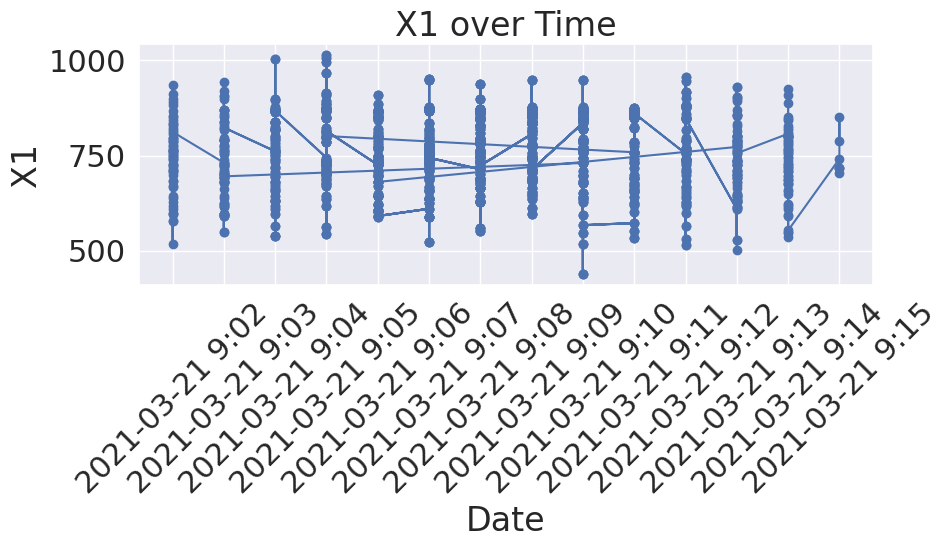

In [ ]:
import matplotlib.pyplot as plt

# Slice the DataFrame to include the first 2000 rows
X_subset = X_test.iloc[0:2000]

# Create a plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(X_subset['date'], X_subset['X1'], marker='o')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('X1')
plt.title('X1 over Time')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()       # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
X_train = X_train.drop(columns=['date','chunk','fragment'], axis=1)
X_test  = X_test.drop(columns=['date','chunk','fragment'], axis=1)

In [ ]:
print(len(X_test))
print(len(X_train))

81000
210500


In [ ]:
print ('Select every {}th row'.format(NUMBER_TIMESTEPS))

Y_train_short = Y_train[::NUMBER_TIMESTEPS]
Y_test_short  = Y_test[::NUMBER_TIMESTEPS]
print ('Y bunches (train, test):')
print(Y_train_short.shape)
print(Y_test_short.shape)

Select every 500th row
Y bunches (train, test):
(421, 12)
(162, 12)


In [ ]:
Y_train_short = Y_train_short.drop(columns=['date'], axis=1)
Y_test_short  = Y_test_short.drop(columns=['date'], axis=1)

Y_train_short = Y_train_short['left-2'] #2
Y_test_short  = Y_test_short['left-2']

In [ ]:
# count the number of NaN per column
nan_counts = X_train.isna().sum()
print(nan_counts['l_degr'])
print(nan_counts['r_degr'])
print(nan_counts['l_shoulder'])
print(nan_counts['r_shoulder'])

156
103
24
59


In [ ]:
# TRAIN
X_train['l_degr'].fillna(90, inplace=True)
X_train['r_degr'].fillna(90, inplace=True)
X_train['l_shoulder'].fillna(90, inplace=True)
X_train['r_shoulder'].fillna(90, inplace=True)

# TEST
X_test['l_degr'].fillna(90, inplace=True)
X_test['r_degr'].fillna(90, inplace=True)
X_test['l_shoulder'].fillna(90, inplace=True)
X_test['r_shoulder'].fillna(90, inplace=True)

In [ ]:
# count the number of NaN per column
nan_counts = X_train.isna().sum()
print(nan_counts['l_degr'])
print(nan_counts['r_degr'])
print(nan_counts['l_shoulder'])
print(nan_counts['r_shoulder'])

0
0
0
0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Applying Min-Max Scaling to scale the features to the range [0, 1]
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(scaler.fit_transform(X_test ), columns=X_test.columns )

X_train.head()

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,X6,Y6,X7,Y7,X8,Y8,X9,Y9,X10,Y10,l_degr,r_degr,l_shoulder,r_shoulder
0,0.613907,0.616236,0.574186,0.587458,0.589691,0.615083,0.585169,0.595101,0.540056,0.650659,0.533348,0.564733,0.496365,0.795657,0.519033,0.633564,0.442947,0.776760,0.563433,0.616553,0.591842,0.161793,0.765630,0.550020
1,0.653562,0.564630,0.623600,0.537622,0.619326,0.545555,0.626050,0.536373,0.566495,0.543766,0.564347,0.468345,0.533308,0.688171,0.586730,0.532505,0.538938,0.692883,0.564341,0.588129,0.894257,0.583599,0.769619,0.157257
2,0.489741,0.536754,0.443793,0.499483,0.420854,0.506467,0.425898,0.491145,0.376429,0.478917,0.349969,0.416672,0.421567,0.575186,0.344533,0.496669,0.487439,0.674951,0.396364,0.518637,0.972160,0.200955,0.766049,0.531873
3,0.544338,0.551836,0.501185,0.531527,0.522056,0.536733,0.516856,0.534463,0.531464,0.549520,0.400385,0.496088,0.621738,0.649958,0.357755,0.593867,0.625813,0.663377,0.455687,0.604903,0.648154,0.153182,0.782764,0.738864
4,0.701772,0.636435,0.667932,0.606140,0.680494,0.618148,0.661067,0.578078,0.647249,0.623945,0.551265,0.512742,0.601373,0.757090,0.452045,0.631891,0.548555,0.792790,0.430122,0.706192,0.852417,0.717085,0.606183,0.590836


In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
print ('X (train, test):')
print(X_train.shape)
print(X_test.shape)

X (train, test):
(210500, 24)
(81000, 24)


In [ ]:
print('2 classes:')
NUMBER_BATCH_TRAIN = X_train.shape[0] // NUMBER_TIMESTEPS
print('X_train = ', X_train.shape)
print('NUMBER_BATCH_TRAIN = ',NUMBER_BATCH_TRAIN)
X_train = np.reshape(X_train, (NUMBER_BATCH_TRAIN, NUMBER_TIMESTEPS, NUMBER_FEATURES))
print('X_train = ', X_train.shape)

NUMBER_BATCH_TEST = X_test.shape[0] // NUMBER_TIMESTEPS
print('X_test = ', X_test.shape)
print('NUMBER_BATCH_TEST = ',NUMBER_BATCH_TEST)
X_test = np.reshape(X_test, (NUMBER_BATCH_TEST, NUMBER_TIMESTEPS, NUMBER_FEATURES))

print('X_test = ', X_test.shape)

2 classes:
X_train =  (210500, 24)
NUMBER_BATCH_TRAIN =  421
X_train =  (421, 500, 24)
X_test =  (81000, 24)
NUMBER_BATCH_TEST =  162
X_test =  (162, 500, 24)


In [ ]:
!pip install keras-tcn

In [ ]:
X_train.shape[0]

421

In [ ]:
from tcn import TCN
from keras.regularizers import l1,l2
from tensorflow import keras
from tensorflow.keras.optimizers.schedules import ExponentialDecay

epochs = 20

lr=0.002 #initial
final_lr = 0.000001
decay_rate = 0.00000000005

steps_per_epoch = NUMBER_BATCH_TRAIN #int(X_train.shape[0] // NUMBER_TIMESTEPS)
learn_rate_decay_factor = (final_lr / lr)**(1/epochs)

lr_schedule = ExponentialDecay(
    initial_learning_rate = lr,
    decay_steps           = steps_per_epoch, #100000
    decay_rate            = learn_rate_decay_factor, #0.96
    staircase=True)

print ('Steps per epoch = {}'.format(steps_per_epoch) )
print ('Learning rate decay factor = {}'.format(learn_rate_decay_factor) )

def build_model(NUMBER_OUTPUTS, NUMBER_FEATURES):
    model = models.Sequential()
    # an input layer that expects:
    # 1 or more samples, NUMBER_TIMESTEPS time steps and NUMBER_FEATURES features.

    # 1st LSTM layer
    #model.add(layers.LSTM(256, return_sequences=True, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    #model.add(layers.Dropout(0.2))

    # 2nd LSTM layer
    #model.add(layers.LSTM(512, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    #model.add(layers.Dropout(0.2))

    model.add(TCN(512, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES), kernel_size=3, nb_stacks=1, dilations=[1, 2, 4, 8, 16, 32, 64, 128]  ) )

    # Hidden fully connected layers of the neural network
    # l1 or l2
    model.add(layers.Dense(256,activation='relu', kernel_regularizer=l2(0.001)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(512,activation='relu', kernel_regularizer=l2(0.001)) )
    model.add(layers.Dropout(0.3)) #0.2 or 0.5
    model.add(layers.Dense(256,activation='relu', kernel_regularizer=l1(0.01)) )
    model.add(layers.Dropout(0.3)) #0.2 or 0.5

    # Classification layer of the neural network
    model.add(layers.Dense(NUMBER_OUTPUTS, activation='sigmoid')) #softmax=multiple sigmoid=2

    opt = Adam(amsgrad=True, learning_rate=lr_schedule) #learning_rate=learn_rate)#, beta_1=0.9, beta_2=0.999)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','Precision','Recall' ]) # categorical_crossentropy #,'accuracy', 'Precision','Recall'

    # this shows the network structure
    model.summary()

    return model


Steps per epoch = 421
Learning rate decay factor = 0.6838305520458344


In [ ]:
# creating the model
model = build_model(NUMBER_OUTPUTS=1, NUMBER_FEATURES=NUMBER_FEATURES)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_2 (TCN)                 (None, 512)               11854336  
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               131584    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dropout_8 (Dropout)         (None, 256)              

In [ ]:
'''
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the learning rate decay function
def lr_decay(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * decay_rate ^ (epoch / decay_steps)

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_decay)
'''

'\nfrom tensorflow.keras.callbacks import LearningRateScheduler\n\n# Define the learning rate decay function\ndef lr_decay(epoch, lr):\n  if epoch < 10:\n    return lr\n  else:\n    return lr * decay_rate ^ (epoch / decay_steps)\n\n# Create a LearningRateScheduler callback\nlr_scheduler = LearningRateScheduler(lr_decay)\n'

In [ ]:
# training the model

# fit model
history = model.fit( X_train, Y_train_short, validation_data=(X_test, Y_test_short), epochs=epochs, batch_size = 64) #, callbacks=[lr_scheduler])

Epoch 1/20
7/7 [==============================] - 40s 3s/step - loss: 255.0453 - accuracy: 0.5344 - precision: 0.6877 - recall: 0.5979 - val_loss: 54.9711 - val_accuracy: 0.4074 - val_precision: 0.4074 - val_recall: 1.0000
Epoch 2/20
7/7 [==============================] - 7s 985ms/step - loss: 53.6670 - accuracy: 0.5558 - precision: 0.6818 - recall: 0.6701 - val_loss: 51.1235 - val_accuracy: 0.4074 - val_precision: 0.4074 - val_recall: 1.0000
Epoch 3/20
7/7 [==============================] - 6s 867ms/step - loss: 49.3965 - accuracy: 0.6508 - precision: 0.6935 - recall: 0.8866 - val_loss: 47.2267 - val_accuracy: 0.4074 - val_precision: 0.4074 - val_recall: 1.0000
Epoch 4/20
7/7 [==============================] - 6s 951ms/step - loss: 45.6164 - accuracy: 0.6295 - precision: 0.6810 - recall: 0.8729 - val_loss: 43.6916 - val_accuracy: 0.4074 - val_precision: 0.4074 - val_recall: 1.0000
Epoch 5/20
7/7 [==============================] - 6s 847ms/step - loss: 42.2432 - accuracy: 0.6770 - prec

In [ ]:
'''
# Save the entire model (architecture, optimizer state, and weights)
model.save('trained_model.h5')

# Alternatively, you can save just the weights
model.save_weights('model_weights.h5')

from tensorflow.keras.saving import load_model
# Load the entire model from the .h5 file
loaded_model = load_model('trained_model.h5')
'''


'''
# Calling `save('my_model.keras')` creates a zip archive `my_model.keras`.
model.save("stroke_nihss_1.keras")

# It can be used to reconstruct the model identically.
loaded_model = keras.models.load_model("stroke_nihss_1.keras")

# Summary of the loaded model
loaded_model.summary()
'''

'\n# Calling `save(\'my_model.keras\')` creates a zip archive `my_model.keras`.\nmodel.save("stroke_nihss_1.keras")\n\n# It can be used to reconstruct the model identically.\nloaded_model = keras.models.load_model("stroke_nihss_1.keras")\n\n# Summary of the loaded model\nloaded_model.summary()\n'

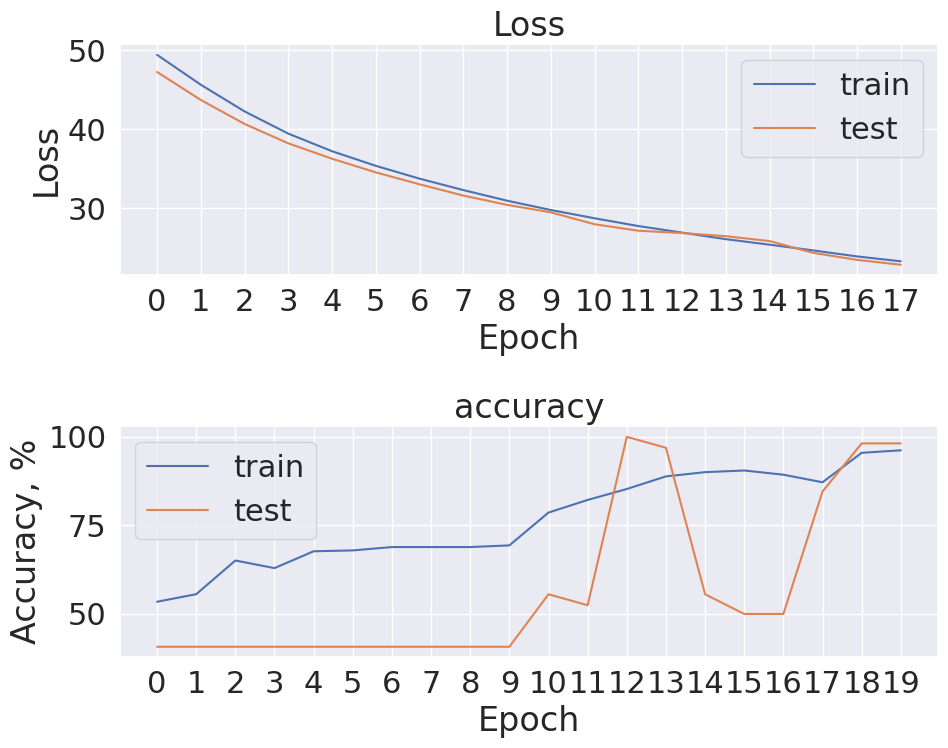

In [ ]:
from matplotlib import pyplot as plt

# Create a larger figure
plt.figure(figsize=(10, 8))

# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'][2:], label='train')
plt.plot(history.history['val_loss'][2:], label='test')
plt.legend()
plt.xticks(range(len(history.history['loss'][2:])))
plt.xlabel('Epoch')
plt.ylabel('Loss')

# plot accuracy during training
plt.subplot(212)
plt.title('accuracy')
#plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='test')
plt.plot([acc * 100 for acc in history.history['accuracy']], label='train')
plt.plot([acc * 100 for acc in history.history['val_accuracy']], label='test')
plt.xticks(range(len(history.history['accuracy'])))
plt.xlabel('Epoch')
plt.ylabel('Accuracy, %')

# Adjust spacing between subplots
plt.tight_layout()
plt.legend()

# Save the figure as an image file
plt.savefig('training_results.png')

plt.show()

14/14 [==============================] - 3s 191ms/step


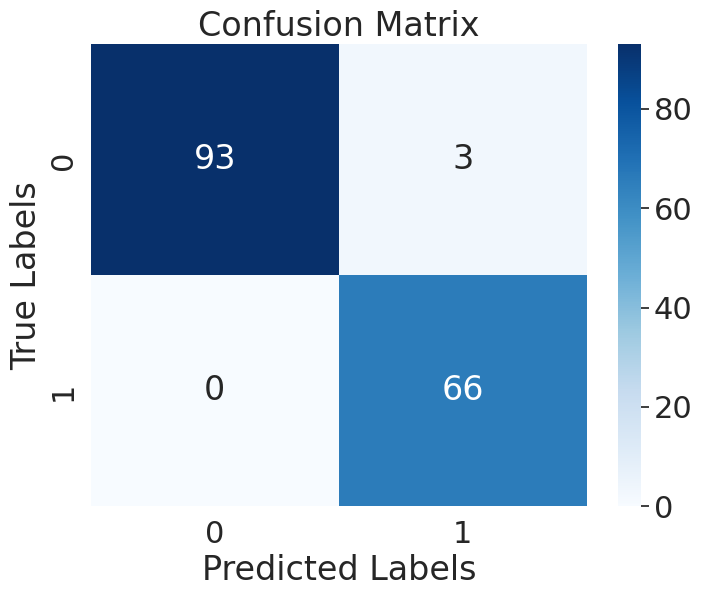

In [ ]:
#NEW CODE# Step 1: Make Predictions# Step 2: Convert Probabilities to Classes using a threshold (e.g., 0.5)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred_prob_test = model.predict(X_test)
threshold = 0.5
Y_test_model = (y_pred_prob_test > threshold).astype(int)

y_pred_prob_train = model.predict(X_train)
threshold = 0.5
Y_train_model = (y_pred_prob_train > threshold).astype(int)

# Step 3: Calculate Confusion Matrix
conf_matrix = confusion_matrix(Y_test_short, Y_test_model)

# Step 4: Visualize Confusion Matrix (Optional)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
# Predict outputs and save them in a variable
'''Y_train_model = model.predict(X_train)
Y_test_model = model.predict(X_test)'''


'Y_train_model = model.predict(X_train)\nY_test_model = model.predict(X_test)'

In [ ]:
#Y_train_model

In [ ]:

# Cast the float array to an integer array
# Create a pandas Series from the array
'''y_pred = (Y_train_model > threshold).astype(int)
y_pred = (Y_test_model > threshold).astype(int)
Y_train_model = pd.Series(Y_train_model.astype(int).flatten())
Y_test_model  = pd.Series(Y_test_model.astype(int).flatten())'''

'y_pred = (Y_train_model > threshold).astype(int)\ny_pred = (Y_test_model > threshold).astype(int)\nY_train_model = pd.Series(Y_train_model.astype(int).flatten())\nY_test_model  = pd.Series(Y_test_model.astype(int).flatten())'

In [ ]:
Y_train_model

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

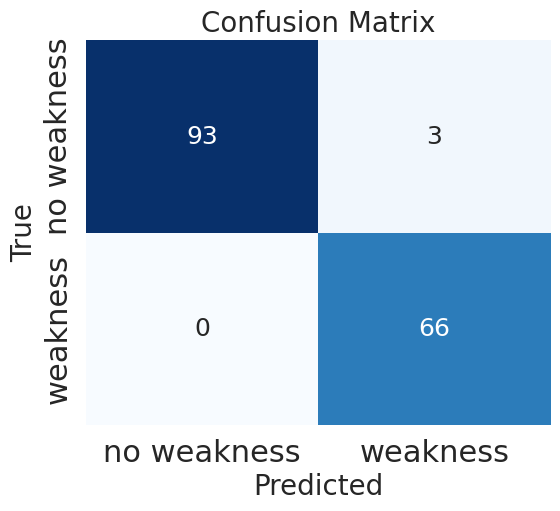

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Sample predicted and true values
#predicted = np.array([1, 0, 1, 1, 0, 1, 0, 1, 0, 1])
#true = np.array([1, 0, 0, 1, 0, 1, 0, 0, 0, 1])

predicted = Y_test_model
true      = Y_test_short

# Calculate confusion matrix
cm = confusion_matrix(true, predicted)
#cm = [[453629,246371],[165458,284674]]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 5))
#sns.heatmap(cm, annot=True,  cmap="Blues", xticklabels=["minor", "moderate"], yticklabels=["minor", "moderate"]) #fmt="d",

sns.set(font_scale = 2)
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["no weakness", "weakness"], yticklabels=["no weakness", "weakness"], cbar=False, annot_kws={"size": 18}) #fmt="d",
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
plt.title('Confusion Matrix', fontsize=20)


# Save the figure as an image file
plt.savefig('confusion_matrix.png')

plt.show()

In [ ]:
Y_train_model = pd.Series(Y_train_model.astype(int).flatten())
Y_test_model  = pd.Series(Y_test_model.astype(int).flatten())

In [ ]:
Y_train_model.value_counts(normalize=False)

1    305
0    116
dtype: int64

In [ ]:
Y_test_model.value_counts(normalize=False)

0    93
1    69
dtype: int64

In [ ]:
Y_train_short.value_counts(normalize=False)

1    291
0    130
Name: left-2, dtype: int64

In [ ]:
Y_test_short.value_counts(normalize=False)

0    96
1    66
Name: left-2, dtype: int64

In [ ]:
print(history.history)

{'loss': [255.0453338623047, 53.666954040527344, 49.39645004272461, 45.616363525390625, 42.24324035644531, 39.435272216796875, 37.21198272705078, 35.3648567199707, 33.741783142089844, 32.300804138183594, 30.958662033081055, 29.780588150024414, 28.73600196838379, 27.753238677978516, 26.921693801879883, 26.095306396484375, 25.399213790893555, 24.669321060180664, 23.913673400878906, 23.29532241821289], 'accuracy': [0.5344418287277222, 0.5558194518089294, 0.6508313417434692, 0.6294536590576172, 0.6769596338272095, 0.6793349385261536, 0.6888360977172852, 0.6888360977172852, 0.6888360977172852, 0.6935867071151733, 0.786223292350769, 0.8218527436256409, 0.8527315855026245, 0.8883610367774963, 0.900237500667572, 0.9049881100654602, 0.8931116461753845, 0.8717339634895325, 0.9548693299293518, 0.9619952440261841], 'precision': [0.687747061252594, 0.6818181872367859, 0.6935483813285828, 0.6809651255607605, 0.6876513361930847, 0.6911764740943909, 0.692307710647583, 0.6904761791229248, 0.69047617912

6/6 [==============================] - 1s 150ms/step


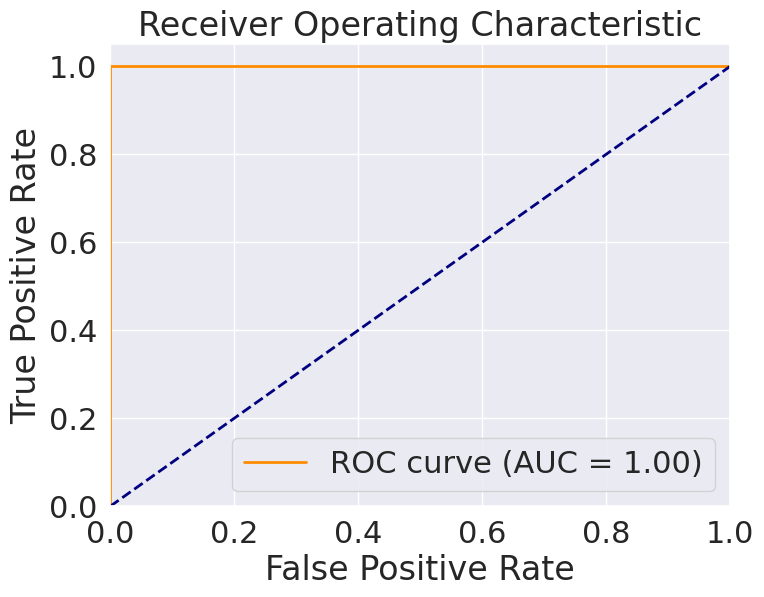

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Make Predictions
y_pred_prob = model.predict(X_test)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_short, y_pred_prob)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()